# Test a meta-reinforcement learning model (A2C) on the two-step task

## What is meta-reinforcement learning?

TODO: explain meta-reinforcement learning

### Let's setup the environment

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What is the two step task, and why should I care?

P1: explain model-free and model-based behavior in cognitive science

P2: two-step task is an iconic experiment demonstrating that humans have the ability to learn in a model-based manner.

P3: add maybe a figure to explain how the two-step task should work.

## Finally, let's train the model

In [ ]:
# specify the agent and the environment
numLstmUnits = 10
numSharedLayerUnits = 5
numTrainSteps = 7e+5
policy_kwargs = {'n_lstm': numLstmUnits, 'shared_layer_size': numSharedLayerUnits, 'action_noise': 0}
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)

do_experiment(env, policy_kwargs, numTrainSteps)

In [12]:
def do_experiment(env, policy_kwargs, numTrainSteps):
    """
    Launch an experiment.
    """
    
    from stable_baselines.bench.monitor import Monitor
    from stable_baselines import DQN, PPO2, A2C, ACKTR
    import os
    from stable_baselines.common.cmd_util import make_vec_env
    from policies.policies import CustomLSTMNoisyActionPolicy

    # create a log path to store models and monitor files
    modelPath = './A2C-LSTM{}_StaticAction_Share{}_PSwitch5e-2'.format(numLstmUnits, numSharedLayerUnits)
    if not os.path.exists(modelPath):
        os.mkdir(modelPath)

    # monitor and wrap the environment
    # TODO: should try to see whether n_envs can be > 1 
    env = Monitor(env, modelPath)
    env_wrapped = make_vec_env(lambda: env, n_envs=1)

    # specify model
    model = A2C(CustomLSTMNoisyActionPolicy, env, verbose=1, policy_kwargs=policy_kwargs, \
            gamma = 0.9, vf_coef = 0.05, ent_coef = 0.05, n_steps = 20, \
            tensorboard_log=os.path.join(modelPath, 'tensorboard'))

    
    save_step = 25000
    for step in range(save_step, numTrainSteps, save_step):
        model.learn(save_step, log_interval=1000, reset_num_timesteps=False)
        model.save(modelPath + '/train' + str(step))
    
    del env

## Let's visualize the model performance
### Some of the visualization is still in active coding phase.

In [5]:
from sklearn.decomposition import PCA

# visualize the hidden states
# only do hidden layer output for now
def visualizeH(ax, Rollouts, NStable = 10):
    Nhidden = Rollouts.states_hidden.shape[2]//2
    
    # use the first half of episodes to fit pca
    X_fit = Rollouts.states_hidden[:(Rollouts.NTestEpisodes // 2), :, Nhidden:]
    X_reshaped = np.reshape(X_fit, (-1, X_fit.shape[2]))
    pca = PCA(n_components=3)
    pca.fit(X_reshaped)
    X_test = Rollouts.states_hidden[(Rollouts.NTestEpisodes // 2):, :, Nhidden:]
    X_test_reshaped = np.reshape(X_test, (-1, X_test.shape[2]))
    X_pj = pca.transform(X_test_reshaped)
    
    print('explained variance ratio is: ', pca.explained_variance_ratio_)
    print('{} variance explained by 3 components'.format(np.sum(pca.explained_variance_ratio_)))
    stableTrials = []
    # visualize the 10 trials before switches
    #for epi in range(Rollouts.NTestEpisodes):
    for epi in range(0, 1):
        switchIdx = Rollouts.Switched[epi, :].nonzero()[0]
        #print(switchIdx + epi*Rollouts.NTrials)
        for i in switchIdx:
            idx = i + epi * Rollouts.NTrials
            if i >= NStable:
                stableTrials.extend(np.arange(idx - NStable, idx)) 
    
    stableTrials = np.unique(np.array(stableTrials))
    bestArm = Rollouts.bestArm.flatten()
    color = [0 if x == 0 else 1 for x in bestArm.tolist()]
    color = np.array(color)
    
    # option 1: visualize the stable trials right before switching
    # ideally should see two blobs corresponding to the rewarding arm
    #vis = ax.scatter(X_pj[stableTrials, 0], X_pj[stableTrials, 1], c = color[stableTrials], cmap = 'seismic')
     
        
    # option 2: plot bestArm against X_pj[:,0]
    ax.plot(1 + np.arange(Rollouts.NTrials), X_pj[:Rollouts.NTrials, 0], 'red', label='1st PC')
    ax.plot(1 + np.arange(Rollouts.NTrials), 2+X_pj[:Rollouts.NTrials, 1], 'orange', label = '2nd PC')
    ax.plot(1 + np.arange(Rollouts.NTrials), 4+X_pj[:Rollouts.NTrials, 2], 'yellow', label = '3rd PC')
    ax.legend()
    vis = ax.plot(1 + np.arange(Rollouts.NTrials), bestArm[:Rollouts.NTrials], 'blue', label = 'rewarding arm')
    
    #visualize the states along the first 2 pca components
    #vis = ax.scatter(X_pj[:,0], X_pj[:,1], c=np.arange(0, 1, 1/Rollouts.NTrials), cmap = 'copper')
    
    # calculate the correlation between projected axis and bestArm
    # bestArm is the only independent factor I can think of now...
    for i in range(X_pj.shape[1]):
        corrcoefs = []
        for epi in range(X_test.shape[0]):
            corrcoef = np.corrcoef(X_pj[epi*Rollouts.NTrials:(epi+1)*Rollouts.NTrials,i], Rollouts.bestArm[epi + Rollouts.NTestEpisodes//2])
            corrcoefs.append(corrcoef[0, 1])    
        print('correlation between {}th pca component and bestArm is {.2f}'.format(i, np.mean(corrcoefs)))
    
    # calculate the correlation between raw axis and bestArm
    for i in range(X_test.shape[2]):
        corrcoefs = []
        for epi in range(X_test.shape[0]):
            corrcoef = np.corrcoef(X_test[epi, :,i], Rollouts.bestArm[epi + Rollouts.NTestEpisodes//2])
            corrcoefs.append(corrcoef[0, 1])    
        print('correlation between {}th hidden unit and bestArm is {.2f}'.format(i, np.mean(corrcoefs)))
    
    print('\n')
    return vis

# How does action noise change the behaviors of models?
# increasing action noise

parsing model names...
n_lstm:  10
parsing model names...
n_lstm:  10
explained variance ratio is:  [0.32685136 0.27563266 0.23768237]
0.8401663955704515 variance explained by 3 components
correlation between 0th pca component and bestArm is -0.04188877162220249
correlation between 1th pca component and bestArm is 0.010232950608494903
correlation between 2th pca component and bestArm is 0.011535591331925336
correlation between 0th hidden unit and bestArm is -0.0052575130609469264
correlation between 1th hidden unit and bestArm is -0.020132836951317144
correlation between 2th hidden unit and bestArm is 0.032970599491451515
correlation between 3th hidden unit and bestArm is 0.01632104776866096
correlation between 4th hidden unit and bestArm is 0.011918250895056923
correlation between 5th hidden unit and bestArm is -0.05539186742320572
correlation between 6th hidden unit and bestArm is 0.05467152643088298
correlation between 7th hidden unit and bestArm is 0.030429582149590195
correlation 

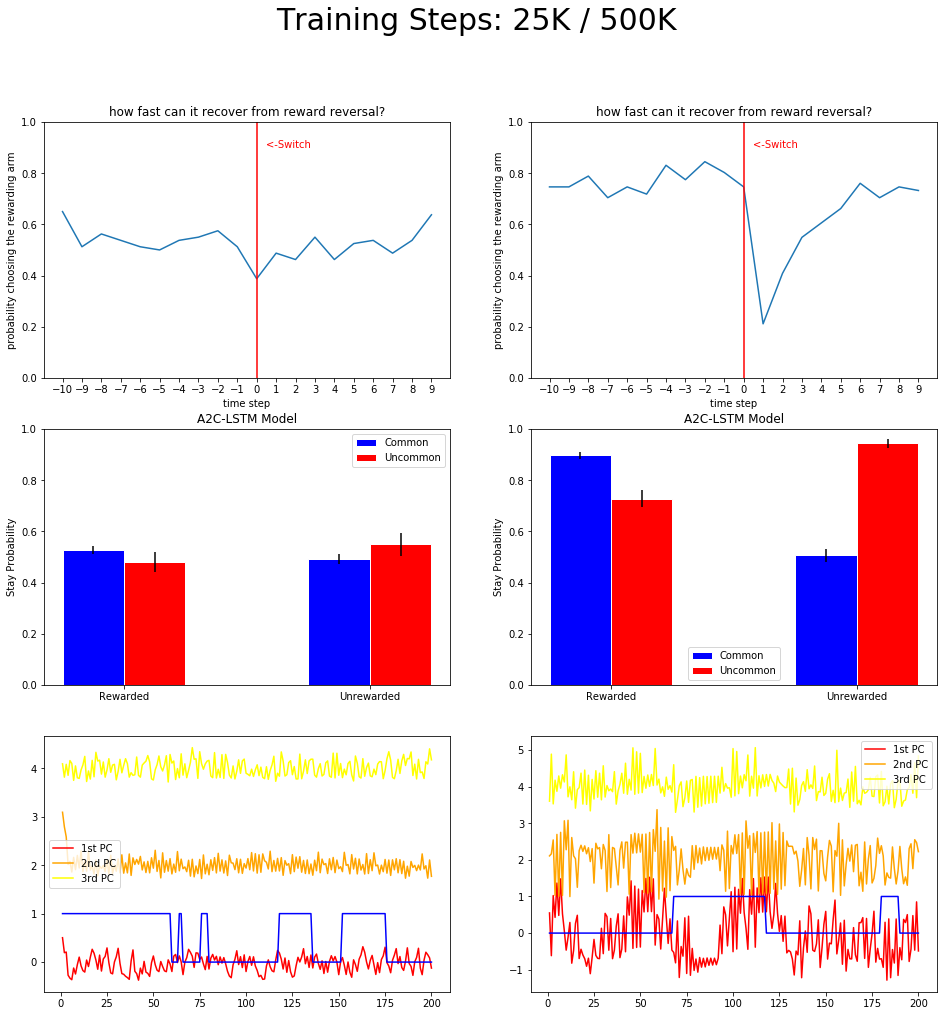

In [6]:
from utils.utils import Simulation, Rollouts, plotActionReversal, calcStayProb, plotStayProb
from envs.TwoStepTask import TwoStepTask
from stable_baselines.common.cmd_util import make_vec_env


env = TwoStepTask(PSwitch = 0.05, NTrials = 200)
env = make_vec_env(lambda: env, n_envs=1)

sims = [Simulation('A2C-LSTM10_Standard_Share5_PSwitch5e-2/train25000', env = env),
              Simulation('A2C-LSTM10_Standard_Share5_PSwitch5e-2/train500000', env = env)]
            
fig, axs = plt.subplots(3, len(sims), figsize = (16, 16))
fig.suptitle('Training Steps: 25K / 500K', fontsize=30)
for ctr, sim in enumerate(sims):
    sim.evaluate()
    
    # first row: how fast can the model switch behaviors after a switch
    plotActionReversal(axs[0, ctr], sim.TestRollouts)
    
    # second row: MB or MF behavior?
    stayProb, _, _ = calcStayProb(sim.TestRollouts)
    plotStayProb(axs[1, ctr], stayProb)
    
    # third row: try to visualize the hidden units
    vis = visualizeH(axs[2, ctr], sim.TestRollouts)